### Import Required Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

import time
import os
import glob
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark == True
plt.ion()

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
# from google.colab import drive
# drive.mount("/content/drive")

In [4]:
# !rm -R drive/MyDrive/data/train/.ipynb_checkpoints
# !ls drive/MyDrive/data/train/ -a

# !rm -R drive/MyDrive/data/val/.ipynb_checkpoints
# !ls drive/MyDrive/data/val/ -a

### Load Data and Image Transformation

In [5]:
data_transforms = {
    "train" : transforms.Compose([
        transforms.RandomResizedCrop(size = (224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val" : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = "/kaggle/input/chicken-duck-data/Image Dataset"
# data_dir = "/content/drive/MyDrive/data"
image_datasets = {x : datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ["train", "val"]}

dataloaders = {x : torch.utils.data.DataLoader(image_datasets[x],
                                               batch_size = 4,
                                               shuffle = True,
                                               num_workers = 2)
                for x in ["train", "val"]}

dataset_sizes = {x : len(image_datasets[x]) for x in ["train", "val"]}

class_names = image_datasets["train"].classes

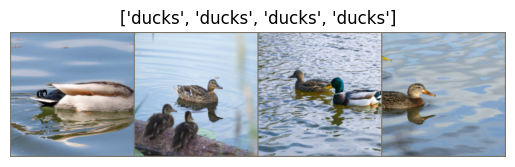

In [6]:
def show_image(input, title = None):
    input = input.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    plt.imshow(input)
    if title is not None:
        plt.title(title)
    plt.axis("off")
    plt.pause(0.001)

inputs, classes = next(iter(dataloaders["train"]))
out = torchvision.utils.make_grid(inputs)
show_image(out, [class_names[x] for x in classes])

### Training the model

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs = 25):
    start_time = time.time()

    ## Create temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, "best_model_params.pt")

        torch.save(model.state_dict(), best_model_params_path)

        best_acc = 0.0
        for epoch in range(num_epochs):
            print("Epoch {}/{}".format(epoch, num_epochs-1))
            print("-"*10)

            ## For each epoch there is a training and validation phase
            for phase in ["train", "val"]:
                if phase == "train":
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                ## Iterate over data
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    ## set the parameter gradients to zero
                    optimizer.zero_grad()

                    ## forward pass
                    with torch.set_grad_enabled(phase == "train"):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        ## backward and optimize when in training phase
                        if phase == "train":
                            loss.backward()
                            optimizer.step()

                    ## statistics
                    running_loss += loss.item()*inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == "train":
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print("{} Loss: {:.4f} Accuracy: {:.4f}".format(phase, epoch_loss, epoch_acc))

                ## deep copy the model
                if phase == "val" and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - start_time
        print("Training completed in {:.0f}m {:.0f}s".format(time_elapsed//60, time_elapsed%60))
        print("Best Validation Accuracy: {:.4f}".format(best_acc))

        ## load best model weights
        model.load_state_dict(torch.load(best_model_params_path))

    return model


### Visualizing the predictions

In [8]:
def visualize(model, num_images = 8):
    was_training = model.training
    model.eval()
    images_idx = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders["val"]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_idx += 1
                ax = plt.subplot(num_images//4, 4, images_idx)
                ax.set_title("Predicted: {}".format(class_names[preds[j]]))
                show_image(inputs.cpu().data[j])

                if images_idx == num_images:
                    model.train(mode = was_training)
                    return
        model.train(mode = was_training)


### Finetune the CNN model Resnet

In [9]:
model_ft = models.resnet18(weights = "IMAGENET1K_V1")
num_features = model_ft.fc.in_features

## size of each output sample
model_ft.fc = nn.Linear(num_features, len(class_names))

model_ft = model_ft.to(device)

## set the loss function
criterion = nn.CrossEntropyLoss()

## To observe that all the parameters all optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr = 0.001, momentum = 0.9)

## Decay LR by a fcator of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size = 7, gamma = 0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 117MB/s] 


### Train and Evaluate

In [10]:
model_ft = train_model(model_ft,
                       criterion,
                       optimizer_ft,
                       exp_lr_scheduler,
                       num_epochs = 25)

Epoch 0/24
----------
train Loss: 0.5433 Accuracy: 0.7550
val Loss: 0.0514 Accuracy: 0.9833

Epoch 1/24
----------
train Loss: 0.1660 Accuracy: 0.9400
val Loss: 0.0406 Accuracy: 1.0000

Epoch 2/24
----------
train Loss: 0.1863 Accuracy: 0.9300
val Loss: 0.0310 Accuracy: 0.9833

Epoch 3/24
----------
train Loss: 0.3677 Accuracy: 0.8750
val Loss: 0.0073 Accuracy: 1.0000

Epoch 4/24
----------
train Loss: 0.3641 Accuracy: 0.8700
val Loss: 0.0234 Accuracy: 0.9833

Epoch 5/24
----------
train Loss: 0.2765 Accuracy: 0.8850
val Loss: 0.1573 Accuracy: 0.9667

Epoch 6/24
----------
train Loss: 0.2803 Accuracy: 0.9100
val Loss: 0.0870 Accuracy: 0.9833

Epoch 7/24
----------
train Loss: 0.2673 Accuracy: 0.9050
val Loss: 0.0262 Accuracy: 0.9833

Epoch 8/24
----------
train Loss: 0.1611 Accuracy: 0.9350
val Loss: 0.0182 Accuracy: 0.9833

Epoch 9/24
----------
train Loss: 0.2264 Accuracy: 0.9300
val Loss: 0.0231 Accuracy: 0.9833

Epoch 10/24
----------
train Loss: 0.2230 Accuracy: 0.9100
val Loss: 0

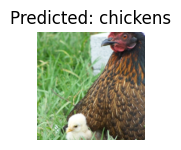

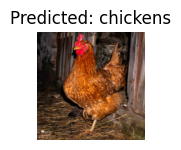

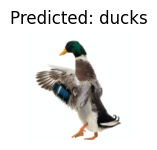

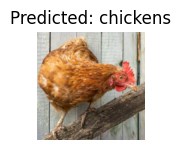

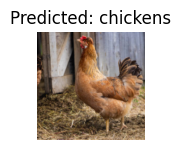

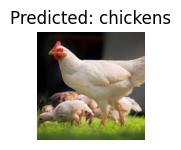

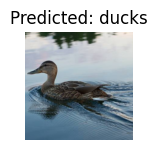

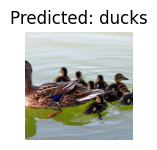

In [11]:
visualize(model_ft)
plt.show()

### CNN as Fixed Feature Extractor

In [12]:
model_conv = models.resnet18(weights = "IMAGENET1K_V1")

for param in model_conv.parameters():
    param.requires_grad = False
    
num_features = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_features, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr = 0.001, momentum = 0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size = 7, gamma = 0.1)

In [13]:
model_conv = train_model(model_conv,
                        criterion,
                        optimizer_conv,
                        exp_lr_scheduler,
                        num_epochs = 25)

Epoch 0/24
----------
train Loss: 0.3996 Accuracy: 0.8050
val Loss: 0.1100 Accuracy: 0.9833

Epoch 1/24
----------
train Loss: 0.5456 Accuracy: 0.7700
val Loss: 0.0837 Accuracy: 0.9667

Epoch 2/24
----------
train Loss: 0.3573 Accuracy: 0.8600
val Loss: 0.0479 Accuracy: 0.9667

Epoch 3/24
----------
train Loss: 0.2824 Accuracy: 0.8650
val Loss: 0.0595 Accuracy: 0.9833

Epoch 4/24
----------
train Loss: 0.2703 Accuracy: 0.8800
val Loss: 0.0756 Accuracy: 0.9833

Epoch 5/24
----------
train Loss: 0.3519 Accuracy: 0.8750
val Loss: 0.0503 Accuracy: 0.9833

Epoch 6/24
----------
train Loss: 0.5190 Accuracy: 0.8050
val Loss: 0.0832 Accuracy: 0.9667

Epoch 7/24
----------
train Loss: 0.2293 Accuracy: 0.8800
val Loss: 0.0517 Accuracy: 0.9667

Epoch 8/24
----------
train Loss: 0.1796 Accuracy: 0.9250
val Loss: 0.0546 Accuracy: 0.9833

Epoch 9/24
----------
train Loss: 0.2955 Accuracy: 0.8500
val Loss: 0.0545 Accuracy: 0.9667

Epoch 10/24
----------
train Loss: 0.2333 Accuracy: 0.9150
val Loss: 0

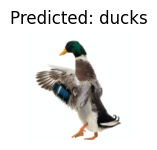

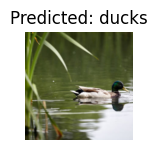

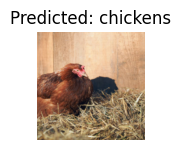

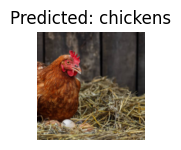

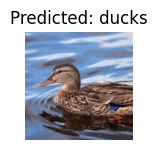

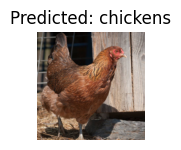

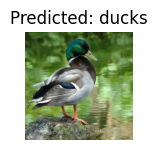

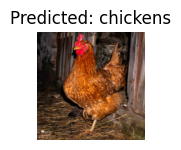

In [14]:
visualize(model_conv)

plt.ioff()
plt.show()

### Inference on Test Images

In [23]:
def visualize_model_predictions(model, image_path, count):
    was_training = model.training
    model.eval()
    
    img = Image.open(image_path)
    img = img.convert("RGB")
    img = data_transforms["val"](img)
    img = img.unsqueeze(0)
    img = img.to(device)
    
    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)
        
        if count < 5:
            plt.title("Predicted: {}".format(class_names[preds[0]]))
            show_image(img.cpu().data[0])
            plt.show()
        
        model.train(mode = was_training)
    return class_names[preds[0]]

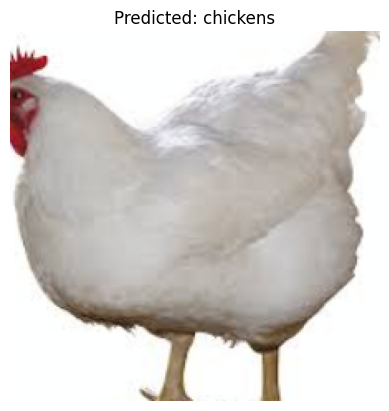

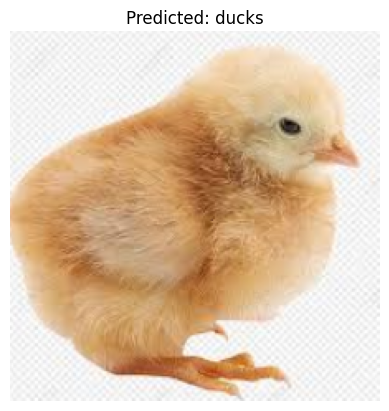

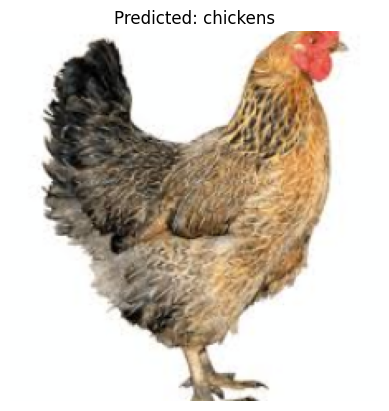

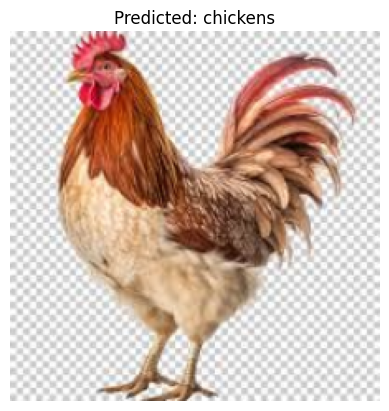

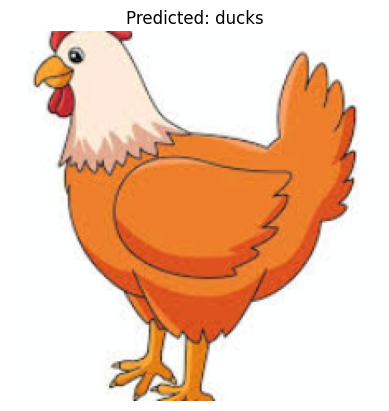

In [24]:
test_images = "/kaggle/input/chicken-duck-data/Image Dataset/test"

chicken_test_images = glob.glob(f"{test_images}/chickens/*")
duck_test_images = glob.glob(f"{test_images}/ducks/*")

y_label_chicken = ["chickens"]*len(chicken_test_images)
y_label_duck = ["ducks"]*len(duck_test_images)

y_pred_chicken = []
y_pred_duck = []

for image_path in chicken_test_images:
    y_pred_chicken.append(visualize_model_predictions(model_conv, image_path, len(y_pred_chicken)))

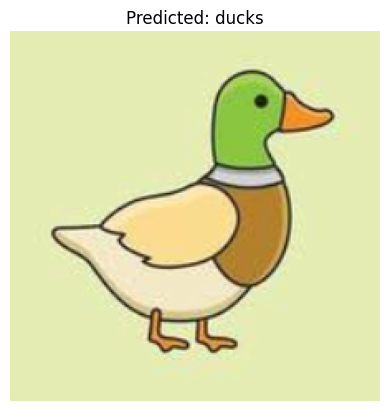

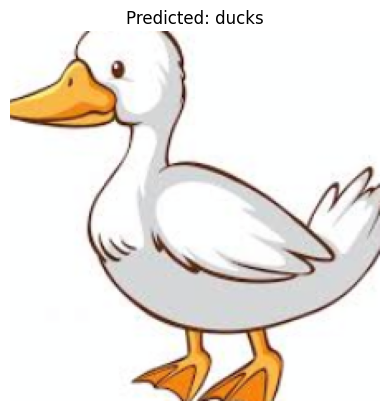

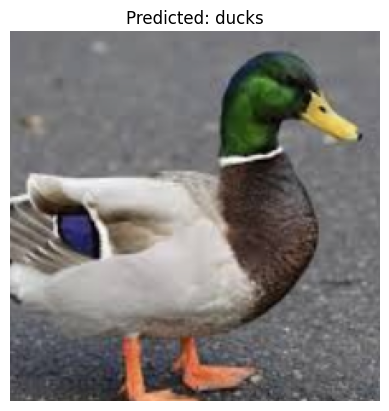

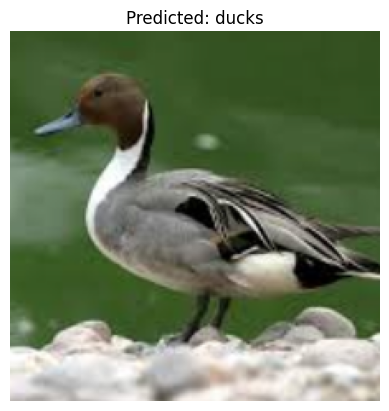

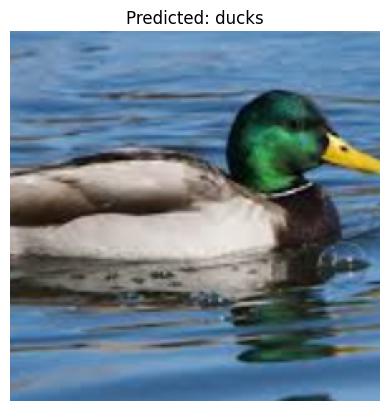

In [25]:
for image_path in duck_test_images:
    y_pred_duck.append(visualize_model_predictions(model_conv, image_path, len(y_pred_duck)))

#### Classification Report

In [27]:
y_label = y_label_chicken + y_label_duck
y_pred = y_pred_chicken + y_pred_duck

print(classification_report(y_label, y_pred))

              precision    recall  f1-score   support

    chickens       0.93      0.69      0.79        36
       ducks       0.76      0.94      0.84        36

    accuracy                           0.82        72
   macro avg       0.84      0.82      0.82        72
weighted avg       0.84      0.82      0.82        72

